# Project 1: Navigation

The following code initialized the Unity environment. If a new agent is trained please restart the kernel.

In [1]:
from unityagents import UnityEnvironment

# create environment
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana_Windows_x86_64/Banana.exe", seed=0) # chnage path of environment if needed
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Trainig

The following code can be used to train the agent. You can change the configuration of the agent as well as which agent and network should be used in the [config.json](config.json) file. This is a list of the configurations:
- **name**: The name of the approach used for saving and loading the agent and its statistics
- **agent**: The name of the agent to use
- **num_episode**: The number of episodes used during training
- **optimistic_init**: Whether the agent should be initalized to a optimistic value
- **agent**: The configurations for the different agent available

Episode 100	Average Score: 0.29	(0.82)
Episode 200	Average Score: 1.39	(0.64)
Episode 300	Average Score: 3.22	(0.46)
Episode 400	Average Score: 7.07	(0.28)
Episode 500	Average Score: 9.81	(0.10)
Episode 600	Average Score: 12.12	(0.09)
Episode 700	Average Score: 13.47	(0.08)
Episode 800	Average Score: 13.62	(0.07)
Episode 900	Average Score: 14.58	(0.06)
Episode 1000	Average Score: 14.83	(0.05)


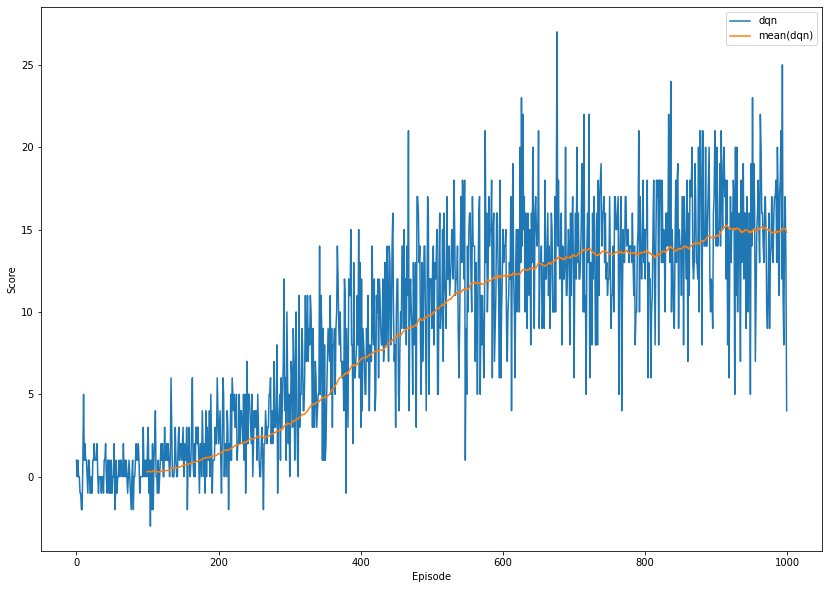

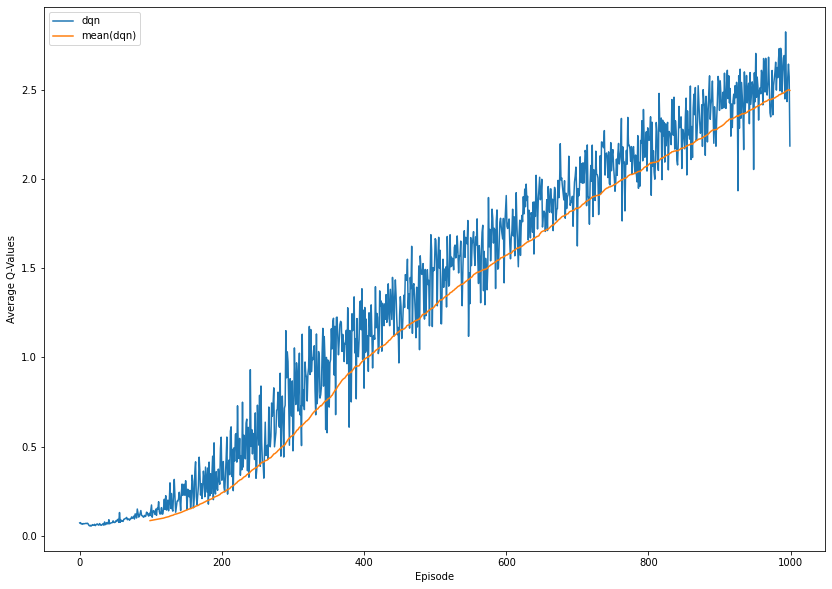

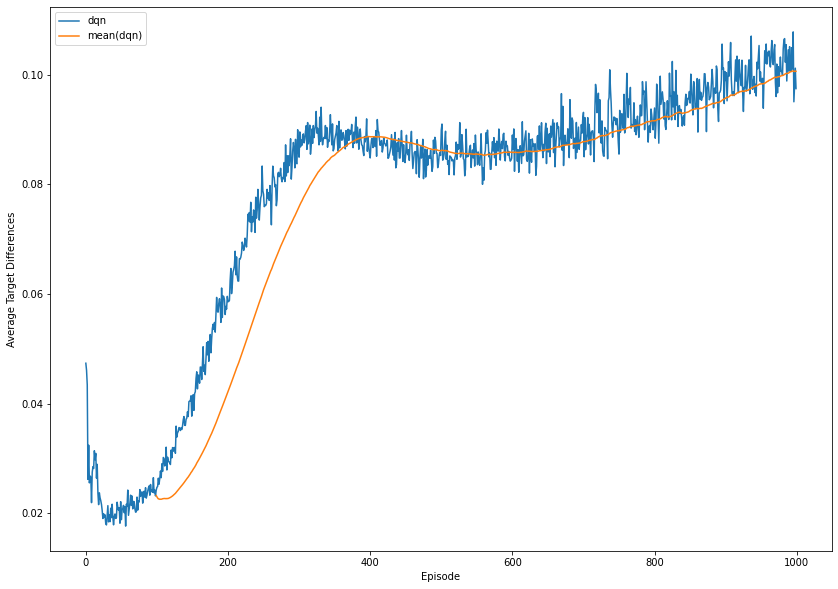

In [2]:
import numpy as np
import json
import os

from importlib import reload
import agents.agents
reload(agents.agents)
from agents.agents import get_agent
import utils.visualizations
reload(utils.visualizations)
import utils.visualizations as vis


# load current config
with open("config.json", "r") as f:
    config = json.load(f)
    
# create results folder
if not os.path.exists("./data"):
    os.mkdir("./data")
if not os.path.exists(f"./data/{config['name']}"):
    os.mkdir(f"./data/{config['name']}")
    
# copy current config to result folder
with open(f"./data/{config['name']}/config.json", "w") as f2:
    json.dump(config, f2)

# get env infos
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])

# create agent
agent = get_agent(config["agent"], config["agents"], state_size, action_size, 0)

# initalizes the value function to return approximately 10 (optimistic value)
if config["optimistc_init"]:
    states = []
    for _ in range(100):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        states.append(state)
        while True:
            action, _ = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            done = env_info.local_done[0]

            state = next_state
            states.append(state)
            if done:
                break 
    agent.optimistic_init(states)

# trains the agent and collect statistics
scores = []
avg_q_values = []
avg_target_diffs = []
for i_episode in range(1, config["num_episodes"]+1):
    score = 0
    q_values = []
    target_diffs = []
    
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    
    # one episode
    while True:
        # select action
        action, value = agent.act(state)
        q_values.append(value)
        
        # get feddback from environment
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        target_diff = agent.step(state, action, reward, next_state, done)
        if target_diff != -1:
            target_diffs.append(target_diff)
        
        state = next_state
        score += reward
        if done:
            # episode ended
            break 
    
    #statistics
    scores.append(score)
    avg_q_values.append(np.mean(q_values))
    avg_target_diffs.append(np.mean(target_diffs))
    if i_episode < 100:
        print('\rEpisode {}\tAverage Score: {:.2f}\t({:.2f})'.format(i_episode, np.mean(scores), agent.epsilon), end="")
    else:
        print('\rEpisode {}\tAverage Score: {:.2f}\t({:.2f})'.format(i_episode, np.mean(scores[-100:]), agent.epsilon), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores[-100:])))
        
# save agent and statistics
agent.save(config["name"])
np.savez(f"./data/{config['name']}/statistics.npz", scores=scores, avg_q_values=avg_q_values, avg_target_diffs=avg_target_diffs)
        
# plot statistics
for show in [False, True]:
    vis.plot_learning_curve([scores], [config["name"]], show=show)
    vis.plot_avg_q_values([avg_q_values], [config["name"]], show=show)
    vis.plot_avg_target_differences([avg_target_diffs], [config["name"]], show=show)
    



## Test

The following code can be used to test the saved agent for one episode. You can change which agent to test in the [config.json](config.json) file.

Score: 11.0


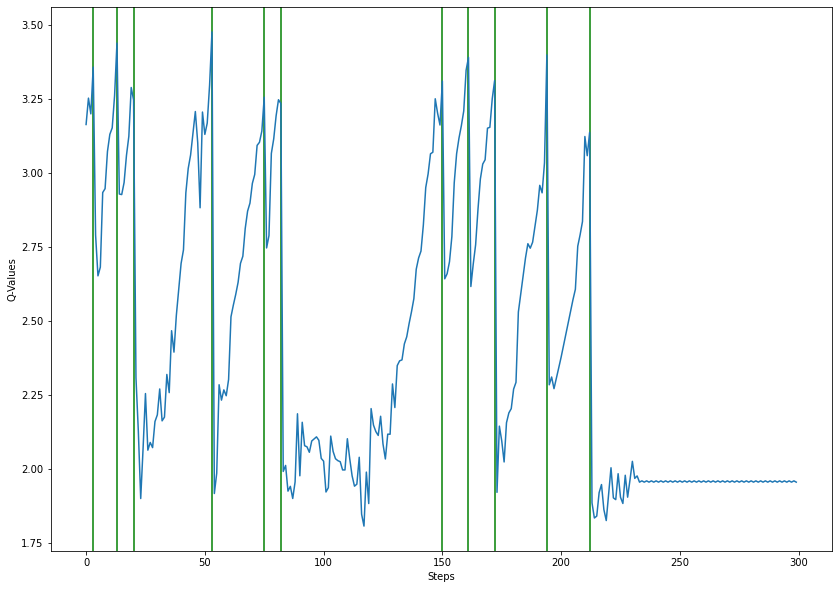

In [3]:
import json

from importlib import reload
import agents.agents
reload(agents.agents)
from agents.agents import get_agent
import utils.visualizations
reload(utils.visualizations)
import utils.visualizations as vis

# load current config
with open("config.json", "r") as f:
    config = json.load(f)
with open(f"./data/{config['name']}/config.json", "r") as f:
    config = json.load(f)

# get env infos
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])

# create agent and load trained parameters
agent = get_agent(config["agent"], config["agents"], state_size, action_size, 0)
agent.load(config["name"])

# one episode test
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0
values = []
rewards = []
while True:
    action, value = agent.act(state, test=True)
    values.append(value)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    rewards.append(reward)
    done = env_info.local_done[0]
    score += reward
    state = next_state
    if done:
        break
    
# statistics
print("Score: {}".format(score))
vis.plot_test_q_values(values, rewards)

If you don't need the environment anymore, you can close it.

In [4]:
env.close()

## Comparison

With the following code you can compare the statistics of different approaches. For this, specify the names of the approaches below (variable: "names").

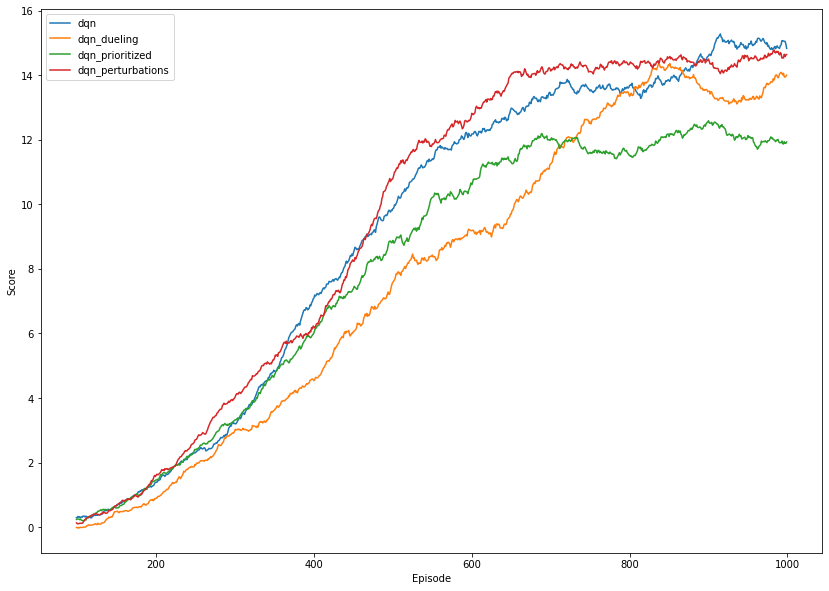

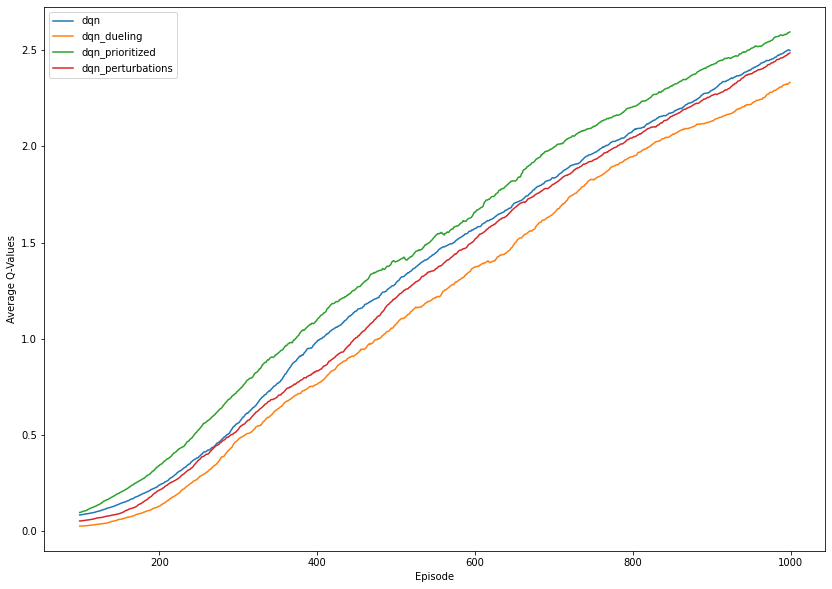

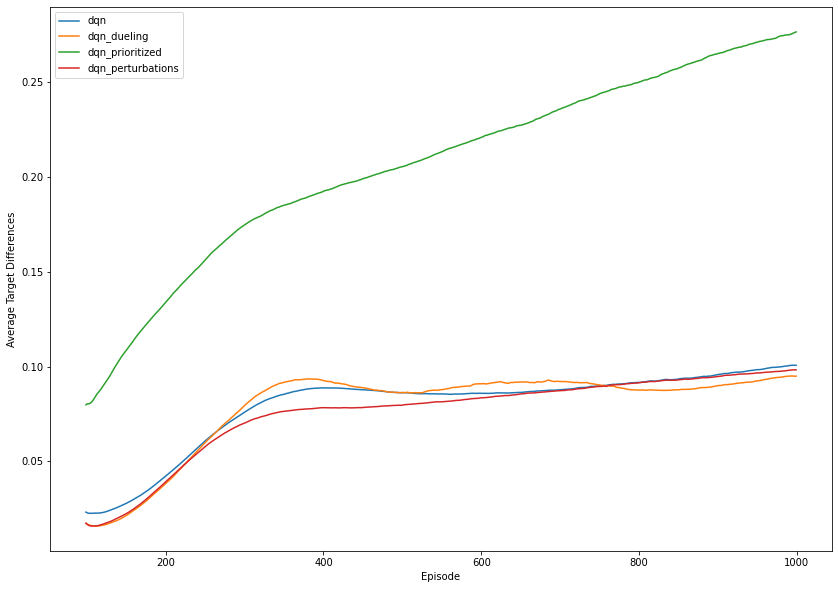

In [9]:
import numpy as np

from importlib import reload
import utils.visualizations
reload(utils.visualizations)
import utils.visualizations as vis

# specify the names of the approaches to compare
names = ["dqn", "dqn_dueling", "dqn_prioritized", "dqn_perturbations"]

# load statistics
scores = []
avg_q_values = []
avg_target_diffs = []
for name in names:
    data = dict(np.load(f"./data/{name}/statistics.npz"))
    scores.append(data["scores"])
    avg_q_values.append(data["avg_q_values"])
    avg_target_diffs.append(data["avg_target_diffs"])
    
# plot statistics
vis.plot_learning_curve(scores, names)
vis.plot_avg_q_values(avg_q_values, names)
vis.plot_avg_target_differences(avg_target_diffs, names)